# Mortal Kombat 2 first steps
In this notebook I analyse first results of experiments in Mortal Kombat 2 env. 

If you scroll down I explain briefly all this code

In [3]:
from stable_baselines3 import PPO
import os
import tempfile
import time
import seaborn as sns
import numpy as np
import re
import pandas as pd

from helpers.saving_utils import get_exp_params, GoogleDriveCheckpointer

# Needed for loading pickle
from MortalKombat2.wrappers import FrameskipWrapper, MaxEpLenWrapper
from stable_baselines3.common.atari_wrappers import WarpFrame
from stable_baselines3.common.monitor import Monitor
import MortalKombat2

sns.set_style("dark", {'axes.grid' : True})

project_name = "miki.pacman/MK2"
google_drive_checkpoints_path = "MK2/saves"
exp_ids = ["MK-18", "MK-17", "MK-16"]

params = get_exp_params("MK-16", project_name)

In [4]:
def get_learning_curve_for_exp(exp_id, env, num_eval_per_checkpoint):
    with tempfile.TemporaryDirectory(dir="/tmp") as temp:
        checkpointer = GoogleDriveCheckpointer(project_experiments_path=google_drive_checkpoints_path, exp_id=exp_id)
        checkpoints_list = checkpointer.get_list_of_checkpoints()
        checkpointer.download_checkpoints(checkpoints_list, temp)

        x, y = [], []
        for root, _, files in os.walk(temp):
            d = {int(re.findall(r"\d+", file)[-1]): file for file in files}
            for xdd in sorted(d.keys())[::-1]:
                r = []
                for _ in range(num_eval_per_checkpoint):
                    file = d[xdd]
                    model = PPO.load(os.path.join(root, file))
                    done = False
                    obs = env.reset()
                    while not done:
                        obs, _, done, info = env.step(model.predict(obs)[0])
                    r.append(info["episode"]["r"])

                y.append(np.mean(r))
                x.append(xdd)
            
    return x, y

In [5]:
df = pd.DataFrame()

for exp_id in exp_ids:
    if exp_id == "MK-16":
        sv = [[0, 1, 2, 3], [5, 6, 7, 8]]
    elif exp_id == "MK-17":
        sv = [[0], [5]]
    elif exp_id == "MK-18":
        sv = [list(range(0, 16)), list(range(16, 32))]
    
    for state_versions in sv:
        params.update({"state_versions": state_versions})
        env = params["env_function"](params, train=True)
        x, y = get_learning_curve_for_exp(exp_id, env, num_eval_per_checkpoint=16)
        df = df.append(pd.DataFrame({
            "num_timesteps": x, 
            "rew": y, 
            "state_versions": [str(params["state_versions"])] * len(x),
            "exp_id": [exp_id] * len(x),
        }), ignore_index=True)
        env.close()

# Number of states during traning
First experiments where performed on setting:
- 1 arena
- VeryEasy difficulty
- against one opponent (Raiden)
- controling one fighter (Scorpion)

The max possible reward is 22 (beating opponent without losing any health)

So I ran PPO on MK2 env with default parameters and standard CNN policy and surprisingly 
it worked out quite nice -> learning curve for training looks good, it reaches maximum.
However when I pritned learning curve for state with same settings, but with different memory state it got worse. 
My explanation fot this is we overfitted to 1 state and failed to generalize to another state with the same settings.
Policy in stochastic which allows for stochastic behaviour of opponent in given state, however as we see
it might not be enough stochastic (opponent can prefer to jump at the beggining of round, so policy learns to react to this
and fails when policy meets different behaviour in other state).

The solution is simple -> add more states with the same settings to provide some variety of behaviours of opponent.

Plots below show 3 traninings, that used 1, 4 and 16 states during training. The blue line shows learning curve on training 
states and orange line shows learning curve on test state (states with the same setting as traning states, but they were
not used during traninig).

# Clearly adding more states ensures better generalization

# 1 state

<AxesSubplot:xlabel='num_timesteps', ylabel='rew'>

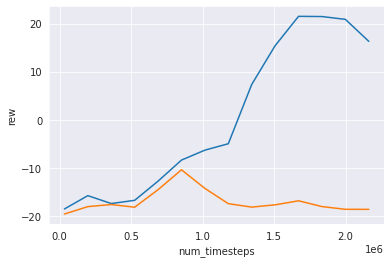

In [17]:
sns.lineplot(data=df[df.exp_id == exp_ids[1]], x="num_timesteps", y="rew", hue="state_versions", legend=False)

# 4 states
here we as see the model starts to overfit after ~4mln steps

<AxesSubplot:xlabel='num_timesteps', ylabel='rew'>

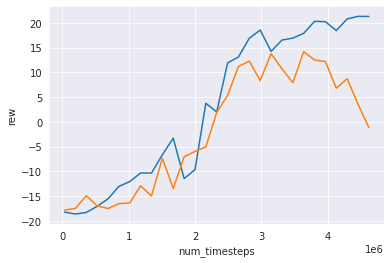

In [18]:
sns.lineplot(data=df[df.exp_id == exp_ids[2]], x="num_timesteps", y="rew", hue="state_versions", legend=False)

# 16 states

<AxesSubplot:xlabel='num_timesteps', ylabel='rew'>

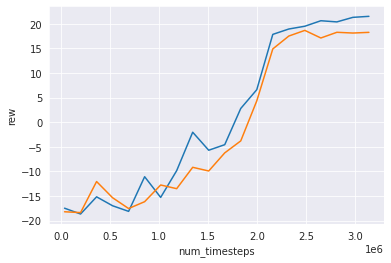

In [19]:
sns.lineplot(data=df[df.exp_id == exp_ids[0]], x="num_timesteps", y="rew", hue="state_versions", legend=False)

# Summary
Use many states during traning to ensure generalization and prevent overfiting